<a href="https://colab.research.google.com/github/Utkarshmishra2k2/Spam-Email-Classification-Comparison-of-Model-Performance-with-and-without-Data-Resampling/blob/main/Spam%20Email%20Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction
Spam email classification is a critical task in the world of machine learning, natural language processing (NLP), and cybersecurity. Spam emails are unsolicited or unwanted messages, often aimed at promoting products, phishing, or spreading malware. The ability to automatically detect and classify these messages as "spam" or "not spam" can save users time, enhance productivity, and improve the security of their email systems.

In this project, we aim to build a spam email classifier using the Naïve Bayes algorithm and compare its performance with and without data resampling techniques like Synthetic Minority Over-sampling Technique (SMOTE). The Naïve Bayes algorithm is widely used for text classification tasks due to its simplicity and effectiveness, especially when the features are conditionally independent, which is a common assumption for text data. We will also explore the impact of data resampling on classifier performance, given that spam datasets are often imbalanced, with far fewer spam emails compared to legitimate ones.

# Why Use Naïve Bayes Algorithm?
The Naïve Bayes (NB) algorithm is particularly suited for text classification tasks, like spam email detection, for the following reasons:

1. Simplicity: Naïve Bayes is simple and computationally efficient, making it easy to implement and fast to train.
2. Effectiveness with Text Data: It works well for high-dimensional data, such as text, by treating each word or feature as independent (the "naïve" assumption).
3. Probabilistic Output: Naïve Bayes provides the probability of a given email being spam or not, making it useful in decision-making.
4. Works Well with Imbalanced Data: While Naïve Bayes assumes feature independence, it often performs well on imbalanced datasets where one class (e.g., non-spam) dominates.


In this project, we will apply the Multinomial Naïve Bayes classifier to predict whether emails are spam or not and compare its performance with and without data resampling.

# Aim of the Project
The primary goal of this project is to:

* Train a spam email classifier using the Naïve Bayes algorithm.
* Evaluate the performance of the model on a real-world email dataset, using metrics like accuracy, precision, recall, and F1-score.
* Compare the model's performance with and without applying data resampling techniques (such as SMOTE) to address class imbalance.

# Importing Libraries


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, roc_curve, auc, precision_recall_curve, classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE

In [2]:
import re
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [3]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# Data Loading and Basic Exploration

In [4]:
import kagglehub
path = kagglehub.dataset_download("jackksoncsie/spam-email-dataset")

In [5]:
data_01 = pd.read_csv(path + "/emails.csv")

In [6]:
data_01.sample(5)

,text,spam
5135,Subject: the light at the end of tunnel ! hi ...,0
1568,"Subject: pres . to delainy sorry vince , plea...",0
2386,Subject: ideas vince : i may have neglected ...,0
549,Subject: free ltci policy comparison software ...,1
3728,Subject: welcome network world fusion focus :...,0


In [7]:
data_01.shape

(5728, 2)

In [8]:
data_01.isnull().sum()

,0
text,0
spam,0


In [9]:
data_01.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5728 entries, 0 to 5727
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    5728 non-null   object
 1   spam    5728 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 89.6+ KB


In [10]:
data_01.describe()

,spam
count,5728.000000
mean,0.238827
std,0.426404
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


# Data Visualization

##  1. Spam Distribution

In [11]:
spam_counts = data_01['spam'].map({1:"Spam",0:"Not Spam"}).value_counts()

fig = px.pie(
    names=spam_counts.index,
    values=spam_counts.values,
    title='Distribution of Spam vs Not Spam Emails',
    color=spam_counts.index,
    color_discrete_map={'Spam': 'lightblue', 'Not Spam': 'pink'},
    labels={'spam_or_not': 'Spam or Not'},
    template='plotly_dark',
    hole=0.3

)

fig.show()

**Conclusion**

1. Proportion of Spam Emails:
The proportion of spam emails is 23.9%. This suggests that approximately one-quarter of the emails analyzed were classified as spam.
2. Proportion of Non-Spam Emails:
The proportion of non-spam emails is 76.1%. This indicates that the majority of emails (approximately three-quarters) were not categorized as spam.
3. Overall Spam Rate:
The overall spam rate is 23.9%. This means that out of every 100 emails, on average, 24 are likely to be spam.

## 2. Text Length Distribution by Spam Classification


In [12]:
data_02 = data_01.copy()

In [13]:
data_02['spam_label'] = data_02['spam'].map({0: 'Not Spam', 1: 'Spam'})
data_02['text_length'] = data_02['text'].apply(len)
fig = px.histogram(data_02, x='text_length', color='spam_label', nbins=50, template='plotly_dark', title='Text Length Distribution by Spam/Not Spam')
fig.show()

**Observation:**

The histogram shows a clear difference in the distribution of text lengths between spam and non-spam messages.

Spam messages tend to have shorter text lengths, with a majority falling within the 0-10k range.
Non-spam messages exhibit a wider range of text lengths, with a significant portion extending beyond 10k characters.


**Interpretation:**

This pattern suggests that text length could be a potential feature for distinguishing spam from non-spam messages. Spammers may often use concise, repetitive messages to maximize their reach, while legitimate messages often contain more detailed content.

In [14]:
fig = px.box(
    data_02,
    x='spam_label',
    y='text_length',
    color='spam_label',
    title='Distribution of Text Length in Emails by Spam Classification',
    color_discrete_map={'spam': 'red', 'not_spam': 'green'},  # Custom color map for spam vs. not_spam
)

fig.update_layout(
    title='Distribution of Text Length in Emails by Spam Classification',
    xaxis_title='Email Classification (Spam or Not Spam)',
    yaxis_title='Text Length (in characters)',
    boxmode='group',
    showlegend=False,
    plot_bgcolor='rgba(0, 0, 0, 0)',
    template='plotly_dark',
    xaxis=dict(
        tickmode='array',
        tickvals=['spam', 'not_spam'],
        ticktext=['Spam Emails', 'Non-Spam Emails']
    ),
    yaxis=dict(
        zeroline=True,
        showgrid=True,
        )
)

fig.show()

**Observation:**

The boxplot shows that spam emails are mostly short, with a median around 500 characters and a few long outliers. Non-spam emails have a wider range and a median of 2,000 characters.

**Interpretation:**

This suggests that text length could help distinguish spam from non-spam, as spam tends to be concise, while non-spam is more detailed.





## 3.1. Word Clouds for Spam and Non-Spam Emails

In [15]:
data_01['text'] = data_01['text'].astype(str)

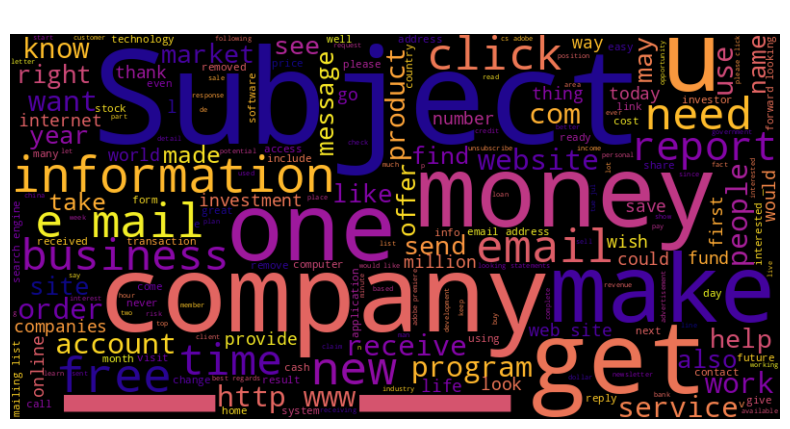

In [16]:
spam_text = " ".join(str(email) for email in data_01[data_01['spam'] == 1]['text'])
stop_words = set(stopwords.words('english'))

spam_wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='black',
    colormap='plasma',
    max_words=200,
    stopwords=stop_words,
    contour_color='white',
    contour_width=2,
    random_state=42
).generate(spam_text)

plt.figure(figsize=(10, 5))
plt.imshow(spam_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Top Words in Spam Emails', fontsize=16, color='white', fontweight='bold')
plt.show()


**Observation:**

The word cloud provides a visual representation of the most frequent words in a dataset, likely related to email content. The size of each word is proportional to its frequency in the text.

**Interpretation:**

* Common Themes: The dominant words like "email," "website," "company," "business,
" "money," "information," and "product" suggest that the dataset is likely composed of emails related to business transactions, marketing, or online activities.
* Action-Oriented: Words like "click," "order," "get," "find," "make," and "need" indicate a focus on action-oriented communication and requests.
* Marketing and Sales: Terms like "offer," "free," "save," and "investment" suggest a marketing or sales context, potentially for online products or services.

## 3.2. Word Clouds for Non-Spam Emails

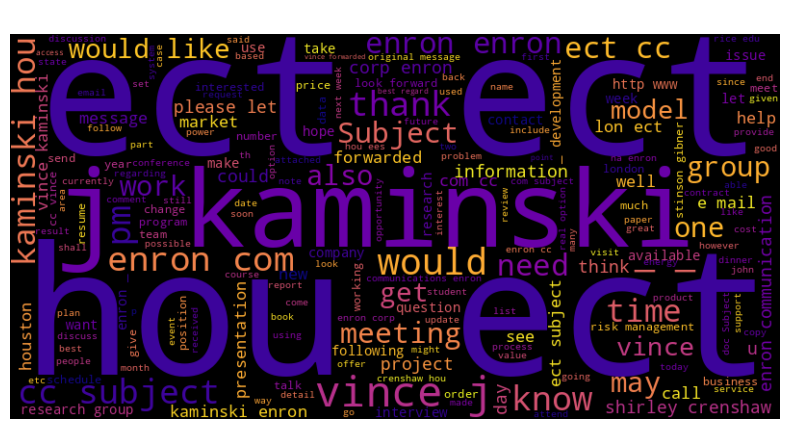

In [17]:
spam_text = " ".join(str(email) for email in data_01[data_01['spam'] == 0]['text'])
stop_words = set(stopwords.words('english'))

spam_wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='black',
    colormap='plasma',
    max_words=200,
    stopwords=stop_words,
    contour_color='white',
    contour_width=2,
    random_state=42
).generate(spam_text)

plt.figure(figsize=(10, 5))
plt.imshow(spam_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Top Words in Not Spam Emails', fontsize=16, color='white', fontweight='bold')
plt.show()


**Observation:**

The word cloud provides a visual representation of the most frequent words in a dataset, likely related to email content. The size of each word is proportional to its frequency in the text.

**Interpretation:**

* Common Themes: The dominant words like "enron," "kaminski," "vince," "subject," "email," "meeting," "project," "would," and "like" suggest that the dataset is likely composed of internal company emails, potentially related to project management or team communication.
* Action-Oriented: Words like "plan," "discuss," "update," "need," and "get" indicate a focus on action-oriented communication and requests.
* Company-Specific: The presence of names like "Kaminski" and "Vince" suggests that the emails might be specific to certain individuals or teams within the company.

In [18]:
def plot_common_words(data, label, title):
    filtered_data = data[data['spam'] == label]

    if filtered_data.empty:
        print(f"No data available for label {label}.")
        return

    vectorizer = CountVectorizer(stop_words='english', max_features=30)
    words_data = vectorizer.fit_transform(filtered_data['text'])

    words = vectorizer.get_feature_names_out()
    counts = words_data.sum(axis=0).A1

    word_counts = pd.DataFrame({'word': words, 'count': counts}).sort_values(by='count', ascending=False)

    fig = px.bar(
        word_counts,
        x='word',
        y='count',
        title=title,
        labels={'word': 'Word', 'count': 'Frequency'},
        color='count',
        color_continuous_scale='Viridis',
        text='count'
    )

    fig.update_layout(
        xaxis_title='Words',
        yaxis_title='Frequency',
        xaxis_tickangle=-45,
        plot_bgcolor='rgba(0, 0, 0, 0)',
        template='plotly_dark',
        showlegend=False
    )

    fig.show()


## 4.1. Common Words in Spam Emails


In [19]:
plot_common_words(data_01, 1, 'Top 30 Most Common Words in Spam Emails')

**Observation:**
The bar chart displays the frequency of the top 30 most common words found in spam emails.

**Interpretation:**

* High-Frequency Words: Words like "subject," "address," "information," and "money" appear frequently in spam emails. These words might be used by spammers to attract attention or to disguise their malicious intent.
* Action-Oriented Words: Words like "click," "free," and "order" are also common, suggesting that spam emails often try to entice recipients to take specific actions, such as clicking on links or providing personal information.
* Technical Terms: Words like "software" and "website" might be used to create a sense of legitimacy or to mask the true nature of the spam email.

## 4.2. Common Words in Non-Spam Emails


In [20]:
plot_common_words(data_01, 0, 'Top 30 Most Common Words in Non-Spam Emails')

**Observation:**

The bar chart displays the frequency of the top 30 most common words found in non-spam emails.

**Interpretation:**

* Common Business Terms: Words like "enron," "kaminski," "vince," "subject," and "meeting" are highly frequent, suggesting a business context.
* Action-Oriented Words: Terms like "know," "thanks," "time," and "energy" indicate a focus on communication, planning, and problem-solving.
* Company-Specific Jargon: The presence of names like "Kaminski" and "Vince" suggests that the emails might be specific to certain individuals or teams within the company.

# Text Preprocessing: Cleaning and Tokenization

In [21]:
def clean_text(text):
    text = text.lower()
    text = re.sub('[^a-zA-Z\s]', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    text = text.strip()
    return text

In [22]:
X_sentences = [clean_text(text) for text in data_01['text']]

# Feature Extraction: TF-IDF Vectorization

In [23]:
vectorizer = TfidfVectorizer(max_features=2500, min_df=5, max_df=0.7, stop_words=stopwords.words('english'))

In [24]:
X = vectorizer.fit_transform(X_sentences).toarray()
Y = data_01["spam"]

# Train-Test Split

In [25]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.20, random_state=42)

In [26]:
print(f"Train Class Distribution:\n{Y_train.value_counts()}")

Train Class Distribution:
spam
0    3504
1    1078
Name: count, dtype: int64




---



# **Without Data Resampling**


# Model Training: Naive Bayes Classifier

In [27]:
model_01 = MultinomialNB()

In [28]:
model_01.fit(X_train, Y_train)

MultinomialNB()

In [29]:
Y_pred_01 = model_01.predict(X_test)

## Model Evaluation

In [30]:
print(f"Test Accuracy: {accuracy_score(Y_test, Y_pred_01):}")

Test Accuracy: 0.9781849912739965


The test accuracy is 97.81%, meaning the model correctly classified 97.81% of the test samples. This shows that the model performs well on new, unseen data, accurately predicting whether an email is spam or not in nearly 98 out of 100 cases.

In [31]:
print(classification_report(Y_test, Y_pred_01, target_names=['Not Spam', 'Spam']))

              precision    recall  f1-score   support

    Not Spam       0.98      0.99      0.99       856
        Spam       0.97      0.94      0.96       290

    accuracy                           0.98      1146
   macro avg       0.98      0.96      0.97      1146
weighted avg       0.98      0.98      0.98      1146



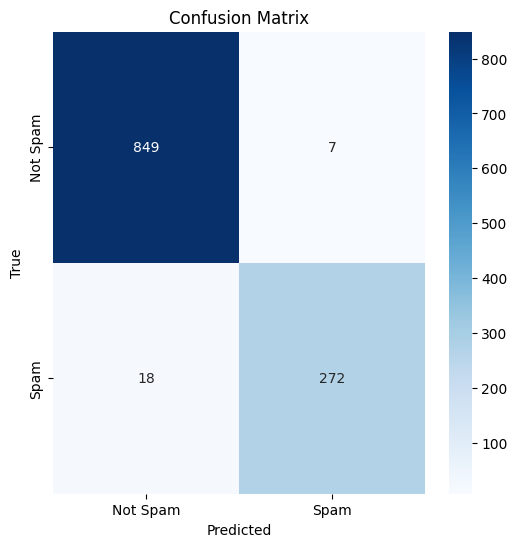

In [32]:
conf_matrix = confusion_matrix(Y_test, Y_pred_01)
fig, ax = plt.subplots(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Not Spam", "Spam"], yticklabels=["Not Spam", "Spam"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

Interpretation:

* True Positives (TP): 849 emails were correctly classified as non-spam.
* True Negatives (TN): 272 emails were correctly classified as spam.
* False Positives (FP): 7 non-spam emails were incorrectly classified as spam.
* False Negatives (FN): 18 spam emails were incorrectly classified as non-spam.


1. **ROC Curve**

In [33]:
y_prob = model_01.predict_proba(X_test)[:,1]
fpr, tpr, _ = roc_curve(Y_test, Y_pred_01)
roc_auc = auc(fpr, tpr)

fig = px.area(
    x=fpr, y=tpr,
    title=f'ROC Curve (AUC = {roc_auc:.2f})',
    labels=dict(x='False Positive Rate', y='True Positive Rate'),
    width=600, height=400
)
fig.add_shape(
    type='line', line=dict(dash='dash'),
    x0=0, x1=1, y0=0, y1=1
)
fig.show()

**Interpretation:**

* AUC Score (0.96): An AUC score of 0.96 indicates that the model has excellent discriminatory power. It is significantly better than a random classifier (which would have an AUC of 0.5).
* ROC Curve Shape: The ROC curve shows that as the false positive rate (FPR) increases, the true positive rate (TPR) also increases, indicating that the model is effectively distinguishing between positive and negative classes.
* Trade-off: The ROC curve highlights the trade-off between sensitivity (TPR) and specificity (1-FPR). Different points on the curve represent different threshold settings, and the optimal threshold can be chosen based on the specific needs of the application.

2. **Precision-Recall Curve**

In [34]:
# Precision-Recall Curve

precision, recall, _ = precision_recall_curve(Y_test, Y_pred_01)
fig = go.Figure()
fig.add_trace(go.Scatter(x=recall, y=precision, mode='lines', name='Precision-Recall Curve'))
fig.update_layout(title="Precision-Recall Curve", xaxis_title="Recall", yaxis_title="Precision")
fig.show()

**Interpretation:**
* High Precision, High Recall: The curve shows that the model achieves high precision and recall across a wide range of thresholds. This indicates that the model is effective in both identifying true positive cases and avoiding false positives.
* Steep Drop: The sharp drop in precision at higher recall values suggests that the model might have difficulty correctly classifying some of the positive cases, leading to a decrease in precision.
* Trade-off: The curve highlights the trade-off between precision and recall. As the threshold for classifying a case as positive is lowered to increase recall, precision might decrease, and vice versa.

#  Cross-Validation

In [35]:
# Cross-validation
cross_val_scores = cross_val_score(model_01, X, Y, cv=5, scoring='accuracy')
print(f"Cross-Validation Accuracy Scores: {cross_val_scores}")
print(f"Mean Cross-Validation Accuracy: {cross_val_scores.mean():}")

Cross-Validation Accuracy Scores: [0.98167539 0.98167539 0.98080279 0.98078603 0.98253275]
Mean Cross-Validation Accuracy: 0.9814944709908016


These results show that the model consistently performs well across different folds, with a mean accuracy of approximately 98.15%, indicating stable and reliable performance.

# Hyperparameter Tuning

In [36]:
# Hyperparameter Tuning with GridSearchCV
param_grid = {'alpha': [0.1, 0.5, 1.0, 2.0, 3.0]}
grid_search = GridSearchCV(MultinomialNB(), param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, Y_train)

GridSearchCV(cv=5, estimator=MultinomialNB(),
             param_grid={'alpha': [0.1, 0.5, 1.0, 2.0, 3.0]},
             scoring='accuracy')

In [37]:
print(f"Best hyperparameters: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_:.2f}")

Best hyperparameters: {'alpha': 0.1}
Best cross-validation score: 0.98


The model's optimal performance was achieved with an alpha value of 0.1, resulting in a high cross-validation score of 98%, indicating that this setting provides the best generalization across the folds.

In [38]:
best_model = grid_search.best_estimator_
Y_pred_best = best_model.predict(X_test)

In [39]:
print(f"Test Accuracy: {accuracy_score(Y_test, Y_pred_best):}")

Test Accuracy: 0.9808027923211169


In [40]:
print(classification_report(Y_test, Y_pred_best, target_names=['Not Spam', 'Spam']))

              precision    recall  f1-score   support

    Not Spam       0.98      0.99      0.99       856
        Spam       0.98      0.94      0.96       290

    accuracy                           0.98      1146
   macro avg       0.98      0.97      0.97      1146
weighted avg       0.98      0.98      0.98      1146



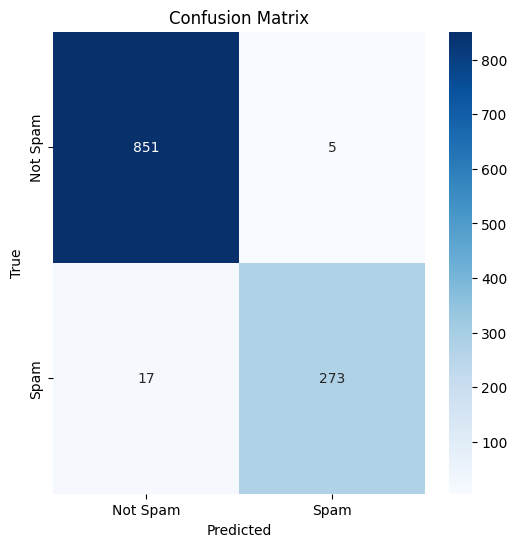

In [41]:
conf_matrix = confusion_matrix(Y_test, Y_pred_best)
fig, ax = plt.subplots(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Not Spam", "Spam"], yticklabels=["Not Spam", "Spam"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# **With Data Resampling {SMOTE}**


# Handling Imbalanced Data using SMOTE (Synthetic Minority Over-sampling Technique)


In [42]:
print(f"Before SMOTE - Train class distribution:\n{Y_train.value_counts()}")

Before SMOTE - Train class distribution:
spam
0    3504
1    1078
Name: count, dtype: int64


In [43]:
smote = SMOTE(random_state=42)
X_train_resampled, Y_train_resampled = smote.fit_resample(X_train, Y_train)

In [44]:
print(f"After SMOTE - Resampled train class distribution:\n{Y_train_resampled.value_counts()}")

After SMOTE - Resampled train class distribution:
spam
0    3504
1    3504
Name: count, dtype: int64


# Model Training: Naive Bayes Classifier

## Model Evaluation

In [45]:
model_02 = MultinomialNB()

In [46]:
model_02.fit(X_train_resampled, Y_train_resampled)

MultinomialNB()

In [47]:
y_pred_02 = model_02.predict(X_test)

In [48]:
print(f"Test Accuracy: {accuracy_score(Y_test, y_pred_02):}")

Test Accuracy: 0.9886561954624782


The test accuracy is 98.86%, meaning the model correctly classified 98.86% of the test samples. This shows that the model performs well on new, unseen data, accurately predicting whether an email is spam or not in nearly 99 out of 100 cases.

In [49]:
print(classification_report(Y_test, y_pred_02, target_names=['Not Spam', 'Spam']))

              precision    recall  f1-score   support

    Not Spam       0.99      0.99      0.99       856
        Spam       0.97      0.98      0.98       290

    accuracy                           0.99      1146
   macro avg       0.98      0.99      0.99      1146
weighted avg       0.99      0.99      0.99      1146



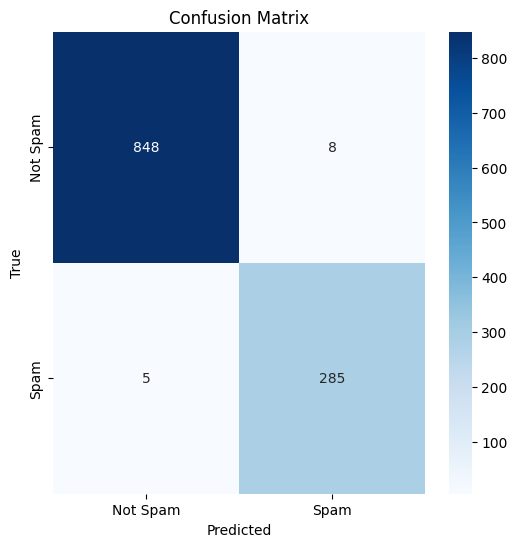

In [50]:
conf_matrix = confusion_matrix(Y_test, y_pred_02)
fig, ax = plt.subplots(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Not Spam", "Spam"], yticklabels=["Not Spam", "Spam"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

Interpretation:

* True Positives (TP): 848 emails were correctly classified as non-spam.
* True Negatives (TN): 285 emails were correctly classified as spam.
* False Positives (FP): 8 non-spam emails were incorrectly classified as spam.
* False Negatives (FN): 5 spam emails were incorrectly classified as non-spam.


1. **ROC Curve**

In [51]:
# Plot ROC Curve

y_prob = model_02.predict_proba(X_test)[:,1]
fpr, tpr, _ = roc_curve(Y_test, y_prob)
roc_auc = auc(fpr, tpr)

fig = px.area(
    x=fpr, y=tpr,
    title=f'ROC Curve (AUC = {roc_auc:.2f})',
    labels=dict(x='False Positive Rate', y='True Positive Rate'),
    width=600, height=400
)
fig.add_shape(
    type='line', line=dict(dash='dash'),
    x0=0, x1=1, y0=0, y1=1
)
fig.show()

2. **Precision-Recall Curve**

In [52]:
# Precision-Recall Curve

precision, recall, _ = precision_recall_curve(Y_test, y_prob)
fig = go.Figure()
fig.add_trace(go.Scatter(x=recall, y=precision, mode='lines', name='Precision-Recall Curve'))
fig.update_layout(title="Precision-Recall Curve", xaxis_title="Recall", yaxis_title="Precision")
fig.show()

#  Cross-Validation

In [53]:
# Cross-validation
cross_val_scores = cross_val_score(model_02, X, Y, cv=5, scoring='accuracy')
print(f"Cross-Validation Accuracy Scores: {cross_val_scores}")
print(f"Mean Cross-Validation Accuracy: {cross_val_scores.mean():}")

Cross-Validation Accuracy Scores: [0.98167539 0.98167539 0.98080279 0.98078603 0.98253275]
Mean Cross-Validation Accuracy: 0.9814944709908016


These results show that the model consistently performs well across different folds, with a mean accuracy of approximately 98.15%, indicating stable and reliable performance.

# Hyperparameter Tuning

In [54]:
# Hyperparameter Tuning with GridSearchCV
param_grid = {'alpha': [0.1, 0.5, 1.0, 2.0, 3.0]}
grid_search = GridSearchCV(MultinomialNB(), param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, Y_train)

GridSearchCV(cv=5, estimator=MultinomialNB(),
             param_grid={'alpha': [0.1, 0.5, 1.0, 2.0, 3.0]},
             scoring='accuracy')

In [55]:
print(f"Best hyperparameters: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_:.2f}")

Best hyperparameters: {'alpha': 0.1}
Best cross-validation score: 0.98


In [56]:
best_model = grid_search.best_estimator_
y_pred_best = best_model.predict(X_test)
print(f"Test Accuracy with best model: {accuracy_score(Y_test, y_pred_best):}")

Test Accuracy with best model: 0.9808027923211169


# Benchmarking

In [57]:
sample_emails = X_test[:10]
sample_labels = Y_test[:10]
sample_predictions = model_02.predict(sample_emails)

In [58]:
sample_predictions

array([0, 0, 0, 0, 0, 1, 0, 0, 0, 1])

In [59]:
print (X_sentences[56])
print (Y[56])

subject localized software all languages available hello we would like to offer localized software versions german french spanish uk and many others aii iisted software is available for immediate downioad no need to wait week for cd deiivery just few exampies norton lnternet security pro windows xp professionai with sp fuil version corei draw graphics suite dreamweaver mx homesite inciudinq macromedia studio mx just browse our site and find any software you need in your native ianguaqe best reqards kayieen
1


In [60]:
print (model_02.predict(vectorizer.transform([X_sentences[56]])))

[1]


# Conclusion:
The project successfully demonstrated the importance of handling imbalanced datasets when building classification models. Without data resampling, the model struggled to correctly classify spam emails due to the imbalance in the dataset. However, after applying SMOTE, the model's ability to classify both spam and non-spam emails improved significantly. This shows that SMOTE is an effective technique for improving the performance of machine learning models when working with imbalanced data.

Further improvements could involve exploring other resampling techniques, such as undersampling the majority class or using more complex models like Random Forests or Gradient Boosting Machines. Additionally, fine-tuning the model with more advanced text representation techniques (e.g., Word2Vec or transformers) could further enhance the classification accuracy.

Ultimately, this project demonstrates the power of preprocessing and resampling techniques in building robust spam email classifiers, which could be applied in real-world email filtering systems to reduce unwanted spam emails efficiently.

In [61]:
print("End")

End
